# Liesel-GAM Demo Notebook

## Setup and Imports

In [1]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [2]:
# import data from R
from ryp import r, to_py

r("library(mgcv)")
r("data(columb)")
r("data(columb.polys)")

columb = to_py("columb", format="pandas").reset_index()
polys = to_py("columb.polys", format="numpy")

Loading required package: nlme
This is mgcv 1.9-3. For overview type 'help("mgcv-package")'.


In [3]:
columb.head()

,index,area,home.value,income,crime,open.space,district,x,y
0,0,0.309441,80.467003,19.531,15.725980,2.850747,0,8.827218,14.369076
1,1,0.259329,44.567001,21.232,18.801754,5.296720,1,8.332658,14.031624
2,2,0.192468,26.350000,15.956,30.626781,4.534649,2,9.012265,13.819719
3,3,0.083841,33.200001,4.477,32.387760,0.394427,3,8.460801,13.716962
4,4,0.488888,23.225000,11.252,50.731510,0.405664,4,9.007982,13.296366


In [4]:
columb["home_value"] = columb["home.value"]

## Model Definition

### Setup response model

In [5]:
df = columb
tb = gam.TermBuilder.from_df(df)

loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


y = lsl.Var.new_obs(
    value=df.crime.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="y",
)

In [6]:
loc += tb.lin("scale(area)*scale(income) + home_value")
loc += tb.lin("x")

### Build and plot model

liesel.model.model - INFO - Converted dtype of Value(name="y_value").value


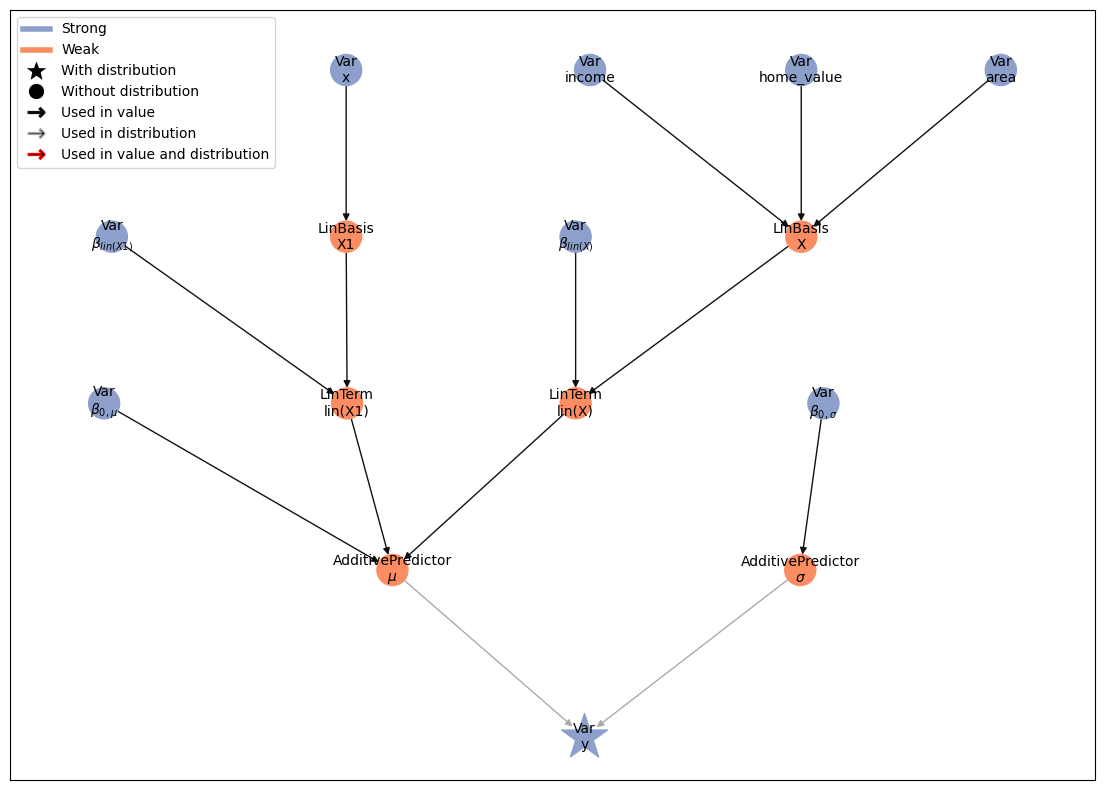

In [7]:
model = lsl.Model([y])
model.plot_vars()

## Run MCMC

In [8]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.set_epochs(
    gs.stan_epochs(
        warmup_duration=4000,
        posterior_duration=10000,
        init_duration=400,
        term_duration=400,
        thinning_posterior=10,
    )
)
engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{lin(X1)}$', '$\\beta_{lin(X)}$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 400 transitions, 25 jitted together
100%|████████████████████████████████████████| 16/16 [00:03<00:00,  4.92chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1039.74chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
100%|████████████████████████████████████████| 2/2 [00:00<00:00, 1424.21chunk/s]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO

### MCMC summary

In [9]:
summary = gs.Summary(results)
summary

Parameter summary:

                             kernel       mean         sd     q_0.05  \
parameter          index                                               
$\beta_{0,\mu}$    ()     kernel_01  33.261314  15.157581   9.007134   
$\beta_{0,\sigma}$ ()     kernel_00   2.444591   0.109798   2.267830   
$\beta_{lin(X)}$   (0,)   kernel_03  -1.445064   1.930990  -4.554711   
                   (1,)   kernel_03  -9.386039   2.177675 -12.968049   
                   (2,)   kernel_03  -0.281708   0.108653  -0.457578   
                   (3,)   kernel_03   1.734924   1.862176  -1.314253   
$\beta_{lin(X1)}$  (0,)   kernel_02   1.353011   1.609763  -1.367244   

                              q_0.5     q_0.95  sample_size     ess_bulk  \
parameter          index                                                   
$\beta_{0,\mu}$    ()     32.996897  58.834418         4000   148.195803   
$\beta_{0,\sigma}$ ()      2.440829   2.626396         4000  2427.508526   
$\beta_{lin(X)}$   (0,)   -1.451347   1.787639         4000  3385.883669   
                   (1,)   -9.431584  -5.815766         4000  2492.684218   
                   (2,)   -0.283364  -0.102806         4000   952.783908   
                   (3,)    1.727691   4.784922         4000  2570.547427   
$\beta_{lin(X1)}$  (0,)    1.350333   3.898762         4000   154.271294   

                             ess_tail      rhat  
parameter          index                         
$\beta_{0,\mu}$    ()      190.423007  1.017643  
$\beta_{0,\sigma}$ ()     3298.096208  1.000288  
$\beta_{lin(X)}$   (0,)   3912.529876  1.000789  
                   (1,)   3118.213226  1.000778  
                   (2,)   1969.202539  1.003394  
                   (3,)   3591.883299  1.000539  
$\beta_{lin(X1)}$  (0,)    184.340598  1.018643  

Error summary:

                                                   count  relative
kernel    error_code error_msg           phase                    
kernel_00 90         nan acceptance prob warmup        2  0.000125
                                         posterior     0       0.0

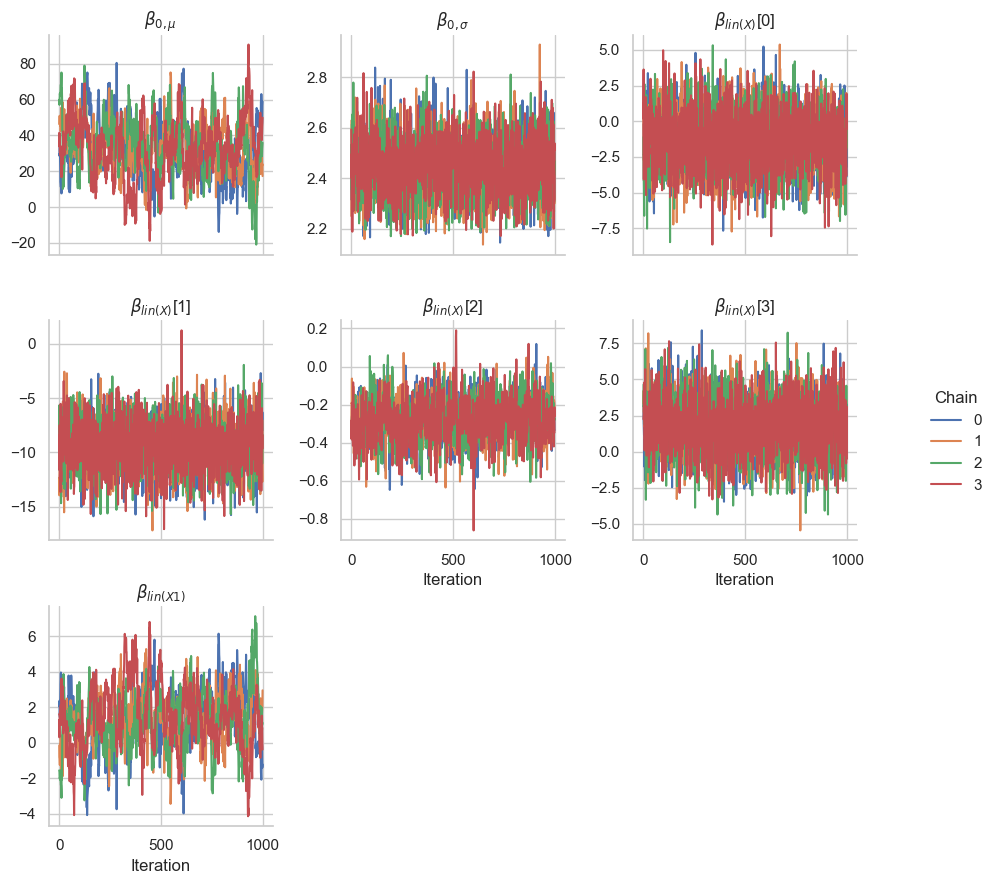

In [10]:
gs.plot_trace(results)

In [11]:
samples = results.get_posterior_samples()

In [12]:
gam.summarise_lin(model.vars["lin(X)"], samples)

,x,sample_size,mean,var,sd,ess_bulk,ess_tail,mcse_mean,mcse_sd,rhat,q_0.05,q_0.5,q_0.95,hdi_low,hdi_high
0,scale(area),4000,-1.445064,3.728721,1.930990,3385.883669,3912.529876,0.033126,0.023223,1.000789,-4.554711,-1.451347,1.787639,-4.626158,1.667472
1,scale(income),4000,-9.386039,4.742268,2.177675,2492.684218,3118.213226,0.043523,0.027294,1.000778,-12.968049,-9.431584,-5.815766,-12.759925,-5.658168
2,home_value,4000,-0.281708,0.011806,0.108653,952.783908,1969.202539,0.003504,0.001953,1.003394,-0.457578,-0.283364,-0.102806,-0.454387,-0.101019
3,scale(area):scale(income),4000,1.734924,3.467701,1.862176,2570.547427,3591.883299,0.036713,0.021313,1.000539,-1.314253,1.727691,4.784922,-1.123274,4.947565


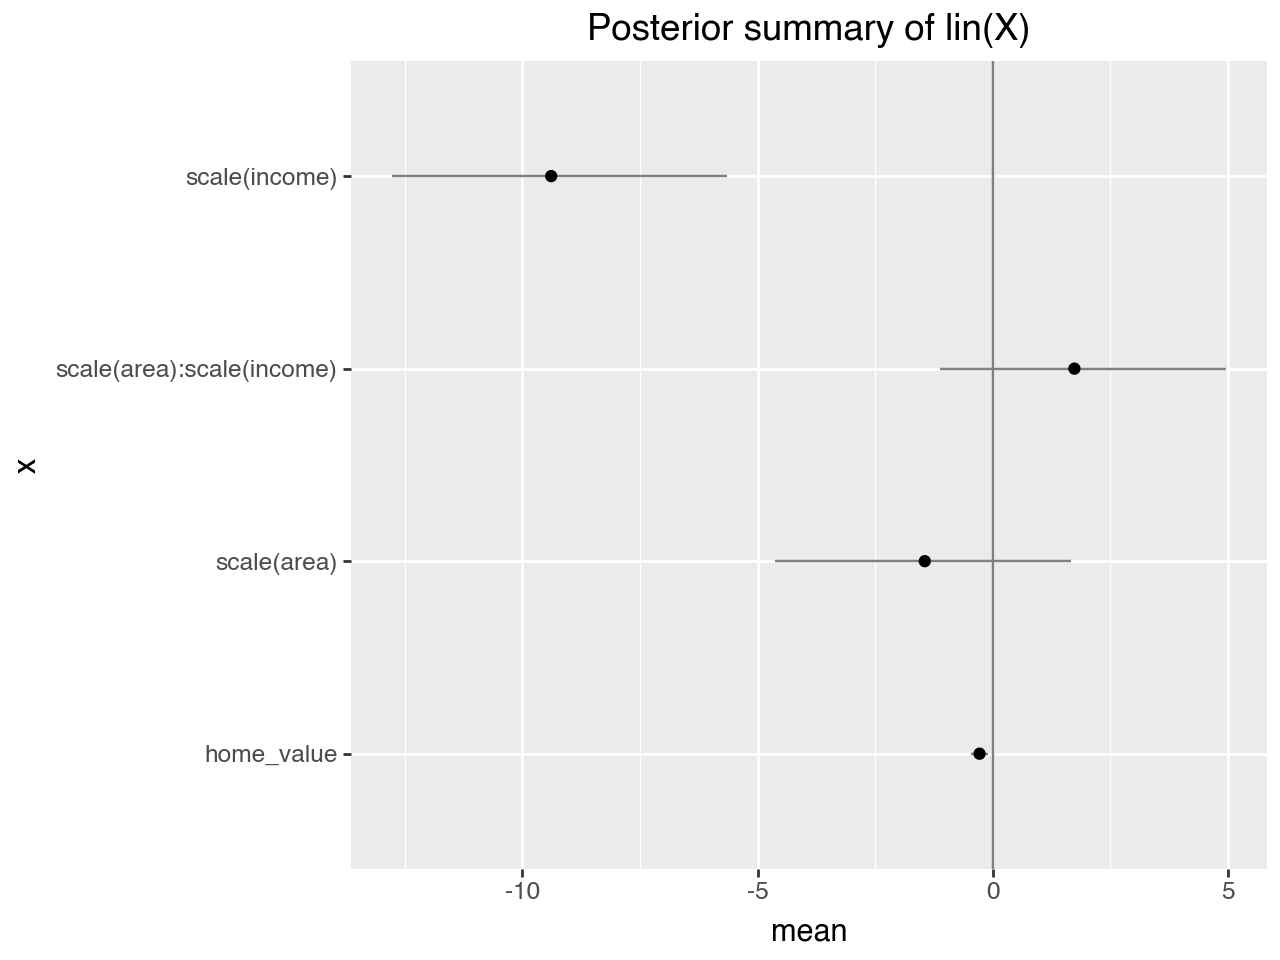

In [13]:
term = model.vars["lin(X)"]
gam.plot_forest(term, samples)